In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import itemfreq
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from scipy.stats.mstats import zscore
#Warnings imported to avoid verbose warnings when the f1 score is ill-defined during the gridsearch
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load dataset

xin= np.load("./X_train.npy")
yin= np.load("./y_train.npy")
xout= np.load("./X_test.npy")

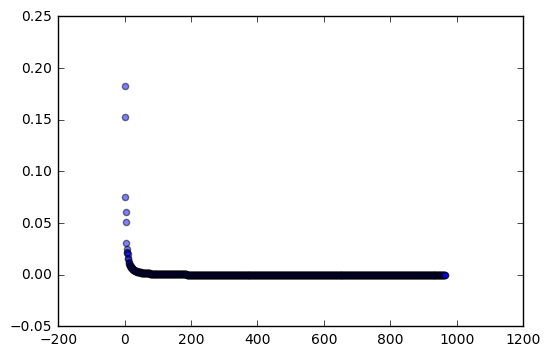

In [3]:
#Elbow analysis for see on how many dimensions to reduce
n_components= 966

pca = PCA(n_components=n_components, svd_solver='auto',
              whiten=True).fit(xin)

X_pca = pca.transform(xin)

y=pca.explained_variance_ratio_

x = np.arange(0, n_components) 
plt.scatter(x, y, alpha=0.5)
plt.show()

In [ ]:
#By doing a elbow analysis on the plot above, it seems the optimal number of features is around these values:

dims=[80, 100, 150, 200]

In [4]:
#Apply dimensionality reduction with PCA
def dimReduction(n_components, X_train):

    h= 50
    w= 37
    t0 = time()
    print("Extracting the top %d features from all the %d features"
          % (n_components, X_train.shape[0]))
    pca = PCA(n_components=n_components, svd_solver='auto',
              whiten=True).fit(X_train)

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the orthonormal basis")
    X_pca = pca.transform(X_train)
    print("Done in %0.3fs" % (time() - t0))
    return X_pca

In [5]:
#Facing the unbalace of the dataset by setting the 
freq= itemfreq(yin)
tot= np.sum(freq[:,1])
sample_weight=(1-(np.sinh(freq[:,1]/(tot)))) 
sample_weight = sample_weight / float(max(sample_weight))

w2= 1.5 - freq[:,1]/max(freq[:,1])
w3= w2/np.sum(w2)

dic3= {0: w3[0],
      1: w3[1],
      2: w3[2],
      3: w3[3],
      4: w3[4],
      5: w3[5],
      6: w3[6],
     }

In [6]:
#Build and evalutate model using the different params provided by params_grid
def buildModel(param_grid, dim, x, y):
    t0 = time()
    x_n= dimReduction(dim, x)
    print("Fitting the classifier to the training set")
    model = GridSearchCV(SVC(decision_function_shape='ovr'),
            param_grid, cv=StratifiedKFold(n_splits=10),
            n_jobs=-1, scoring='f1_macro')
    model = model.fit(x_n, y)
    
    print("done in %0.3fs" % (time() - t0))
    print("DIMENSIONS:")
    print(dim)
    print("ker:")
    print(ker)
    print("Best estimator found by grid search:")
    print(model.best_estimator_)
    print("Best score found by grid search:")
    print(model.best_score_)
    print("Best params found by grid search:")
    print(model.best_params_)
    print("\n")
    return model

In [7]:
#Helper function testing further the model using the confusion matrix
def predict(model, x, y):
    t0 = time()
    print("Predicting on the test set")
    y_pred = model.predict(x)
    print("done in %0.3fs" % (time() - t0))
    print(confusion_matrix(y, y_pred))
    score= f1_score(y, y_pred, average='weighted')
    return score

In [ ]:
#GridsearchCV for rbf kernel with differents params
a=2
expC= np.arange(-5.,17.)
c=np.power(a, expC)

expG= np.arange(-15.,4.)

gam=np.power(a, expG)


param_grid = {'C': c,
              'gamma': gam,
              'kernel':['rbf'],
              'class_weight': ['balanced', dic3]
             }

result=0.0

for i in range(len(dims)):
    model= buildModel(param_grid, dims[i], xin, yin)
    tmp= model.best_score_
    if(tmp > result):
        result=  tmp
        params= model.best_params_
        d= dims[i]

print("\n")
print("Best: ")
print(result)
print("params:")
print(params)
print("dim")
print(d)

In [ ]:
#GridsearchCV for linear kernel with different params
a=2
expC= np.arange(-5.,17.)
c=np.power(a, expC)

param_grid = {'C': c,
              'kernel':['linear'],
              'class_weight': [dic3, balanced]
             }

result=0.0

for i in range(len(dims)):
    model= buildModel(param_grid, dims[i], xin, yin)
    tmp= model.best_score_
    if(tmp > result):
        result=  tmp
        params= model.best_params_
        d= dims[i]

print("\n")
print("Best: ")
print(result)
print("params:")
print(params)
print("dim")
print(d)

In [8]:
#Using square test, for features extraction, not deeply used
def chisq(xin, yin, k):
    
    x_new = SelectKBest(f_classif, k=k).fit_transform(xin,yin)
    
    return x_new

In [9]:
def modChi(ker, param_grid, k, x, y):
    t0 = time()
    xin= chisq(x,y,k)
    print("Fitting the classifier to the training set")
    model = GridSearchCV(SVC(kernel=ker, class_weight='balanced', decision_function_shape='ovr'), param_grid, cv=5, scoring='f1_micro')
    model = model.fit(xin, y)
    
    print("done in %0.3fs" % (time() - t0))
    print("DIMENSIONS:")
    print(k)
    print("ker:")
    print(ker)
    print("Best estimator found by grid search:")
    print(model.best_estimator_)
    print("Best score found by grid search:")
    print(model.best_score_)
    print("Best params found by grid search:")
    print(model.best_params_)
    print("\n")
    return model

In [ ]:
param_grid = {'C': [1],
              'gamma': [0.008, 0.009, 0.0085, 0.01], }

k= [100]

result=0.0

for i in range(len(k)):
    model= modChi('rbf',param_grid, k[i], xin, yin)
    tmp= model.best_score_
    if(tmp > result):
        result=  tmp
        params= model.best_params_
        dim= k[i]

print("\n")
print("Best: ")
print(result)
print("params:")
print(params)
print("dim")
print(dim)

In [ ]:
param_grid = {'C': [100, 50, 20, 10, 1, 0.1, 0.001, 0.0001],
              'gamma': [1, 0.1, 0.01, 0.001, 0.005, 0.0001, 0.0005, 0.000001], 
              'coef0': [0, 0.01, 0.001, 0.0001, 100, 1000]}

result= 0.0

for i in range(len(dims)):
    model= buildModel('sigmoid',param_grid, dims[i], xin, yin)
    tmp= model.best_score_
    if(tmp > result):
        result=  tmp
        params= model.best_params_
        d= dims[i]

print("\n")
print("Best: ")
print(result)
print("params:")
print(params)
print("dim")
print(d)

Extracting the top 150 features from all the 966 features
Projecting the input data on the orthonormal basis
Done in 0.966s


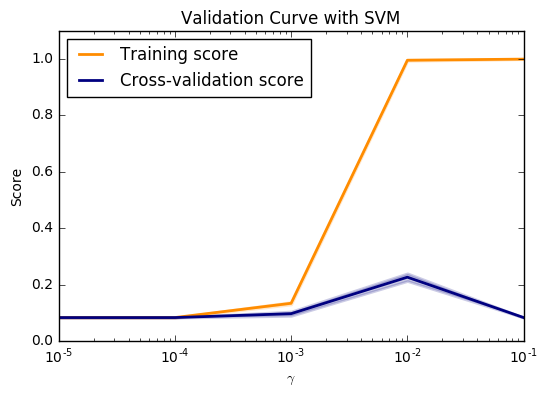

In [10]:
#Visualization of the validation 
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = np.logspace(-5, -1, 5)
x_in= dimReduction(150,xin)
train_scores, test_scores = validation_curve(
    SVC(C=1), x_in, yin, param_name="gamma", param_range=param_range,
    cv=2, scoring="f1_macro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()